In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


## Data Prepration for India
Data is imported from John Hopkins GitHub Repo and can be used for more analysis

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])

full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})

df_india=full_df[full_df['Country']=='India']

world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(-1)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed']
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed']
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed']
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(-1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate']
    return df

df_india=add_rates(df_india)
df=pd.DataFrame(df_india['Confirmed'])
df=df[8:]
df.reset_index(inplace=True,drop=True)

In [0]:
df

Confirmed
0            1
1            1
2            1
3            2
4            3
..         ...
117     150793
118     158086
119     165386
120     173491
121     181827

[122 rows x 1 columns]

In [0]:
data=df['Confirmed'].values

### Scaling the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data.reshape(-1,1))

### Data generation to feed LSTM
creating the batches of data, 1 batch of training data contain 20 values and tagret to predict next data value.

In [0]:
X_Train = []
Y_Train = []

for i in range(20, Train.shape[0]):
    
    X_Train.append(Train[i-20:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(102, 20)
(102,)


### Spliting the data into training and testing
slicing the last 10 data batches for testing purpose 

In [0]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [0]:
X_test=X_Train[-10:,:,:]
y_test=Y_Train[-10:]
X_train=X_Train[0:-10,:,:]
Y_train=Y_Train[0:-10]

In [0]:
print(X_train.shape,Y_train.shape,X_test.shape,y_test.shape)

(92, 20, 1) (92,) (10, 20, 1) (10,)


## Simple LSTM Model

In [0]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_Train.shape[1], 1)))

regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [0]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 4)

Epoch 1/30
102/102 [==============================] - 1s 7ms/step - loss: 0.0182
Epoch 2/30
102/102 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 3/30
102/102 [==============================] - 0s 3ms/step - loss: 3.8184e-04
Epoch 4/30
102/102 [==============================] - 0s 3ms/step - loss: 1.6465e-04
Epoch 5/30
102/102 [==============================] - 0s 3ms/step - loss: 1.3047e-04
Epoch 6/30
102/102 [==============================] - 0s 3ms/step - loss: 9.5720e-05
Epoch 7/30
102/102 [==============================] - 0s 3ms/step - loss: 7.4498e-05
Epoch 8/30
102/102 [==============================] - 0s 3ms/step - loss: 7.0028e-05
Epoch 9/30
102/102 [==============================] - 0s 3ms/step - loss: 6.0526e-05
Epoch 10/30
102/102 [==============================] - 0s 3ms/step - loss: 5.5589e-05
Epoch 11/30
102/102 [==============================] - 0s 3ms/step - loss: 1.4720e-04
Epoch 12/30
102/102 [==============================] - ETA: 0s - loss: 

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

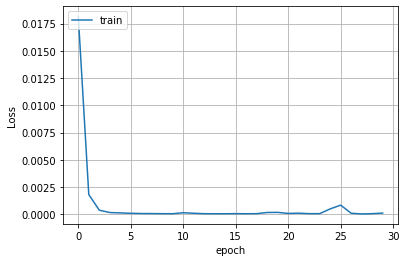

In [0]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [0]:
y_pred=sc.inverse_transform(regressor.predict(X_test))

In [0]:
y_pred

array([[119696.9 ],
       [125628.22],
       [131878.86],
       [138451.11],
       [145355.17],
       [152510.97],
       [159803.19],
       [167210.69],
       [174724.78],
       [182375.25]], dtype=float32)

In [0]:
y_test=sc.inverse_transform(y_test.reshape(-1,1))

In [0]:
y_test

array([[118226.],
       [124794.],
       [131423.],
       [138536.],
       [144950.],
       [150793.],
       [158086.],
       [165386.],
       [173491.],
       [181827.]])

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Confirmed Cases')

Text(0.5, 0, 'Last 10 Days')

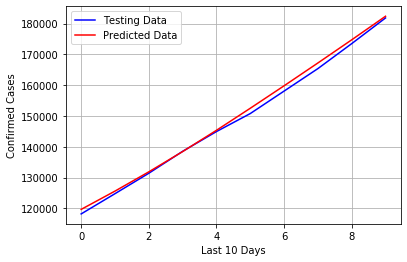

In [0]:
plt.figure()
plt.plot(y_test,label="Testing Data",c="b")
plt.plot(y_pred,label="Predicted Data",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("Last 10 Days")
plt.legend()
plt.grid()
plt.show()

#### Now training the model on full data and forcasting the cases

In [0]:
data=df['Confirmed'].values

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data.reshape(-1,1))

In [0]:
X_Train = []
Y_Train = []

for i in range(20, Train.shape[0]):
    
    X_Train.append(Train[i-20:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(102, 20)
(102,)


In [0]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [0]:
print(X_Train.shape,Y_Train.shape)

(102, 20, 1) (102,)


In [0]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_Train.shape[1], 1)))

regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [0]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 4)

Epoch 1/30
102/102 [==============================] - 1s 7ms/step - loss: 0.0277
Epoch 2/30
102/102 [==============================] - 0s 3ms/step - loss: 7.8920e-04
Epoch 3/30
102/102 [==============================] - 0s 3ms/step - loss: 7.4636e-04
Epoch 4/30
102/102 [==============================] - 0s 3ms/step - loss: 5.3936e-04
Epoch 5/30
102/102 [==============================] - 0s 3ms/step - loss: 3.8627e-04
Epoch 6/30
102/102 [==============================] - 0s 3ms/step - loss: 1.2547e-04
Epoch 7/30
102/102 [==============================] - 0s 3ms/step - loss: 6.2188e-05
Epoch 8/30
102/102 [==============================] - 0s 3ms/step - loss: 6.7665e-05
Epoch 9/30
102/102 [==============================] - 0s 3ms/step - loss: 6.8458e-05
Epoch 10/30
102/102 [==============================] - 0s 3ms/step - loss: 6.1992e-05
Epoch 11/30
102/102 [==============================] - 0s 3ms/step - loss: 6.1440e-05
Epoch 12/30
102/102 [==============================] - 0s 3ms/step 

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

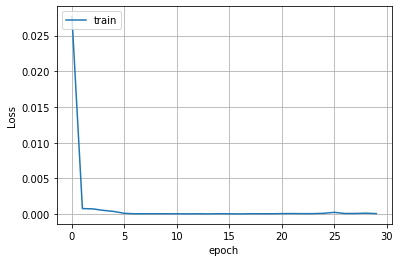

In [0]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [0]:
pred=[]
for i in X_Train[-1]:
    pred.append(i)

## Here predicting the future with sliding window concept
every time top value form batch is poped and model will predict a value which appended to the batch for next prediction

In [0]:
pred.append(regressor.predict(X_Train[-1].reshape(1,20,1)))

In [0]:
forcast=[]
for i in range(30):
    pred.reverse()
    pred.pop()
    pred.reverse()
    forcast.append(sc.inverse_transform(regressor.predict(np.array(pred).reshape(1,20,1))))
    pred.append(regressor.predict(np.array(pred).reshape(1,20,1))) 

array([0.36936412])

array([0.38920176])

array([0.40858293])

array([0.42927854])

array([0.45095861])

array([0.47178621])

array([0.49853706])

array([0.52631087])

array([0.55177477])

array([0.58558182])

array([0.61612201])

array([0.65020954])

array([0.68633199])

array([0.72278992])

array([0.76190974])

array([0.79718522])

array([0.82932034])

array([0.86943011])

array([0.90957839])

array([0.95415397])

array([[0.99711317]], dtype=float32)

array([[1.0392619]], dtype=float32)

array([[1.0818824]], dtype=float32)

array([[1.1247574]], dtype=float32)

array([[1.1676968]], dtype=float32)

array([[1.2105138]], dtype=float32)

array([[1.2530088]], dtype=float32)

array([[1.2950557]], dtype=float32)

array([[1.3364817]], dtype=float32)

array([[1.3770974]], dtype=float32)

In [0]:
future=[]
for i in forcast:
    future.append(i.flatten())

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Confirmed Cases')

Text(0.5, 0, 'No. of Days')

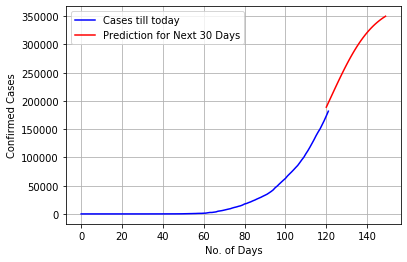

In [0]:
plt.figure()
plt.plot(sc.inverse_transform(Train),label="Cases till today",c="b")
plt.plot(pd.DataFrame(future,index=range(120,150),columns=['Predicted']),label="Prediction for Next 30 Days",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("No. of Days")
plt.legend()
plt.grid()
plt.show()

# ***Analysis:***

In [5]:
confirmed_df.head()

Country/Region Province/State      Lat     Long       date  confirmed
0    Afghanistan            NaN  33.0000  65.0000 2020-01-22          0
1        Albania            NaN  41.1533  20.1683 2020-01-22          0
2        Algeria            NaN  28.0339   1.6596 2020-01-22          0
3        Andorra            NaN  42.5063   1.5218 2020-01-22          0
4         Angola            NaN -11.2027  17.8739 2020-01-22          0

In [7]:
deaths_df.head(5)

Country/Region Province/State      Lat     Long       date  deaths
0    Afghanistan            NaN  33.0000  65.0000 2020-01-22       0
1        Albania            NaN  41.1533  20.1683 2020-01-22       0
2        Algeria            NaN  28.0339   1.6596 2020-01-22       0
3        Andorra            NaN  42.5063   1.5218 2020-01-22       0
4         Angola            NaN -11.2027  17.8739 2020-01-22       0

In [8]:
recoveries_df.head(3)

Country/Region Province/State      Lat     Long       date  recoveries
0    Afghanistan            NaN  33.0000  65.0000 2020-01-22           0
1        Albania            NaN  41.1533  20.1683 2020-01-22           0
2        Algeria            NaN  28.0339   1.6596 2020-01-22           0

In [0]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [0]:
g=confirmed_df.groupby('date')

In [0]:
df2=g.sum()

In [0]:
df2.reset_index(inplace = True, drop = False)

In [17]:
df2.head(2)

date          Lat         Long  confirmed
0 2020-01-22  5625.379563  5995.278262        555
1 2020-01-23  5625.379563  5995.278262        654

In [0]:
g=deaths_df.groupby('date')

In [0]:
df3=g.sum()

In [0]:
df3.reset_index(inplace = True, drop = False)

In [22]:
df3.head(3)

date          Lat         Long  deaths
0 2020-01-22  5625.379563  5995.278262      17
1 2020-01-23  5625.379563  5995.278262      18
2 2020-01-24  5625.379563  5995.278262      26

In [0]:
g=recoveries_df.groupby('date')

In [0]:
df4=g.sum()

In [0]:
df4.reset_index(inplace = True, drop = False)

In [29]:
df4.head(3)

date        Lat         Long  recoveries
0 2020-01-22  5009.7493  7126.560346          28
1 2020-01-23  5009.7493  7126.560346          30
2 2020-01-24  5009.7493  7126.560346          36

# World Cases Analysis

In [31]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Day By Day Confirmed Cases", "Day By Day Death Cases ", "Day By Day Recovery Cases", ))

fig.append_trace(go.Bar(
    x=df2['date'],
    y=df2['confirmed'], name='Confirmed Cases'
), row=1, col=1 )

fig.append_trace(go.Scatter( 
    x=df2['date'],
    y=df2['confirmed'], name='Confirmed Cases'
), row=1, col=1)

fig.append_trace(go.Bar( 
    x=df3['date'],
    y=df3['deaths'], name='Death count'
), row=2, col=1)

fig.append_trace(go.Scatter( 
    x=df3['date'],
    y=df3['deaths'], name='Death Count'
), row=2, col=1)

fig.append_trace(go.Bar( 
    x=df4['date'],
    y=df4['recoveries'], name='Recovery'
), row=3, col=1)
fig.append_trace(go.Scatter( 
    x=df4['date'],
    y=df4['recoveries'], name='Recovery'
), row=3, col=1)



fig.update_layout(height=900, width=700, title_text="Stacked Subplots")
fig.show()

# India Cases Analysis

In [0]:
confirm=confirmed_df.loc[confirmed_df['Country/Region']=='India']

In [0]:
death=deaths_df.loc[deaths_df['Country/Region']=='India']

In [0]:
recover=recoveries_df[recoveries_df['Country/Region']=='India']

In [0]:
data=pd.concat([confirm,death,recover])

In [38]:
data

Country/Region Province/State   Lat  ...  confirmed deaths  recoveries
131            India            NaN  21.0  ...        0.0    NaN         NaN
397            India            NaN  21.0  ...        0.0    NaN         NaN
663            India            NaN  21.0  ...        0.0    NaN         NaN
929            India            NaN  21.0  ...        0.0    NaN         NaN
1195           India            NaN  21.0  ...        0.0    NaN         NaN
...              ...            ...   ...  ...        ...    ...         ...
31750          India            NaN  21.0  ...        NaN    NaN     64277.0
32003          India            NaN  21.0  ...        NaN    NaN     67749.0
32256          India            NaN  21.0  ...        NaN    NaN     70920.0
32509          India            NaN  21.0  ...        NaN    NaN     82627.0
32762          India            NaN  21.0  ...        NaN    NaN     86936.0

[390 rows x 8 columns]

In [0]:
data.reset_index(inplace = True, drop = False)

In [40]:
data.head(5)

index Country/Region Province/State  ...  confirmed  deaths recoveries
0    131          India            NaN  ...        0.0     NaN        NaN
1    397          India            NaN  ...        0.0     NaN        NaN
2    663          India            NaN  ...        0.0     NaN        NaN
3    929          India            NaN  ...        0.0     NaN        NaN
4   1195          India            NaN  ...        0.0     NaN        NaN

[5 rows x 9 columns]

In [0]:
del data['index']

In [0]:
h=data.groupby('date')

In [0]:
india_df=h.sum()

In [0]:
india_df.reset_index(inplace = True, drop = False)

In [45]:
india_df.head(5)

date   Lat   Long  confirmed  deaths  recoveries
0 2020-01-22  63.0  234.0        0.0     0.0         0.0
1 2020-01-23  63.0  234.0        0.0     0.0         0.0
2 2020-01-24  63.0  234.0        0.0     0.0         0.0
3 2020-01-25  63.0  234.0        0.0     0.0         0.0
4 2020-01-26  63.0  234.0        0.0     0.0         0.0

In [0]:
india_df['Mortality_Rate']=india_df['deaths']/india_df['confirmed']

In [0]:
india_df=india_df.replace(np.nan,0)

In [54]:
fig = make_subplots(rows=4, cols=1,subplot_titles=("Total Cases Trend In India", "Death Cases Trend In India ", "Recovery Cases Trend In India", "Mortality Rate Trend In India"))

fig.append_trace(go.Bar(
    x=india_df['date'],
    y=india_df['confirmed'], name='Total Cases'
), row=1, col=1 )

fig.append_trace(go.Bar( 
    x=india_df['date'],
    y=india_df['deaths'], name='Total Deaths'
), row=2, col=1)

fig.append_trace(go.Bar( 
    x=india_df['date'],
    y=india_df['recoveries'], name='Recovery'
), row=3, col=1)

fig.append_trace(go.Bar( 
    x=india_df['date'],
    y=india_df['Mortality_Rate'], name='Mortality'
), row=4, col=1)




fig.update_layout(height=900, width=800, title_text="Stacked Subplots")
fig.show()